## Preprocess Image and Extract Image Features

In [1]:
import json
import numpy as np
import PIL
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

(360, 640, 3) uint8


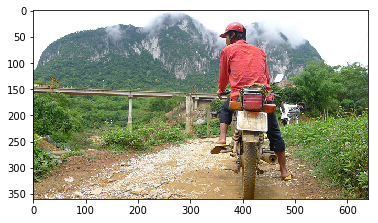

In [2]:
raw = json.load(open('data/coco_raw.json', 'r'))
first_img = raw[0]
image = mpimg.imread('coco/images/' + first_img['file_path'])
print(image.shape,image.dtype)
plt.imshow(image)

(299, 299, 3)


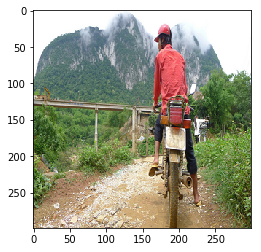

In [3]:
image_pil = Image.open('coco/images/' + first_img['file_path'])
# resize the picture to be 299*299, the dimension used in InceptionResNet input
image_resized = image_pil.resize((299,299),PIL.Image.ANTIALIAS)
# convert to numpy array
image_resized = np.asarray(image_resized, dtype=np.uint8)
print(image_resized.shape)
plt.imshow(image_resized)

In [4]:
import tensorflow as tf
from tensorflow.python.keras.applications import InceptionResNetV2
from tensorflow.python.keras.applications.inception_resnet_v2 import preprocess_input

/home/jiaxing/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
# load InceptionResNetV2 model
model = InceptionResNetV2(include_top=False, weights='imagenet')

In [6]:
print (image_resized.flags) 
# WRITEABLE is False, copy image for preprocessing
cnn_input = image_resized.copy()
# change char array to float array so it is compatible with preprocessing
cnn_input = cnn_input.astype(np.float32)
# extend the dimension, view it as a batch with size 1
cnn_input = np.expand_dims(cnn_input,axis=0)
# preprocess image
cnn_input = preprocess_input(cnn_input)
print (cnn_input.shape)

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : False
  WRITEABLE : False
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False
(1, 299, 299, 3)


In [7]:
output = model.predict(cnn_input)
output = np.squeeze(output,axis=0)
assert output.shape==(8,8,1536)
output = np.reshape(output,(64,1536))
# output dimension is 8*8*1536 before output layer(Figure 9 in paper). 1536 is the number of output channels.
print (output.shape)

(64, 1536)


## Check Result with Stored HDF5 File 

In [8]:
import h5py
import time
import _pickle as cPickle

In [9]:
tic = time.time()
img_features = h5py.File('./data/img_features.hdf5','r')
toc = time.time()
# HDF5 is extremely fast to load!
print ("Time to load file = {} s".format(tic-toc))
print (len(img_features.keys()))

Time to load file = -0.0002574920654296875 s
123050


In [10]:
other_img = cPickle.load(open("data/other_img.p", 'rb'))
# two length should match
print (len(other_img)+len(img_features.keys()),len(raw))

123287 123287


In [11]:
data = img_features[str(first_img['id'])].value
print (np.array_equal(output,data))

True


In [12]:
# Randomly select 10 data from dataset, compare with direct model prediction
total_checked = 0
for i in range(10):
    raw_id = np.random.choice(len(raw))
    img = raw[raw_id]
    image = Image.open('coco/images/' + img['file_path'])
    # resize the picture to be 299*299, the dimension used in InceptionResNet input
    image_resized = image.resize((299,299),PIL.Image.ANTIALIAS)
    # convert to numpy array
    image_resized = np.asarray(image_resized, dtype=np.uint8)
    if image_resized.shape == (299,299,3):
        total_checked += 1
        cnn_input = image_resized.copy()
        cnn_input = cnn_input.astype(np.float32)
        cnn_input = np.expand_dims(cnn_input,axis=0)
        cnn_input = preprocess_input(cnn_input)
        output = model.predict(cnn_input)
        output = np.squeeze(output,axis=0)
        output = np.reshape(output,(64,1536))
        h5_output = img_features[str(img['id'])].value
        if np.array_equal(h5_output,output)==False:
            print ("Something goes wrong with h5_output")
# total checked should around 10. It could be less since there are a few case that the image are not RGB
print (total_checked)

10


In [13]:
img_features.close()

(397, 640)


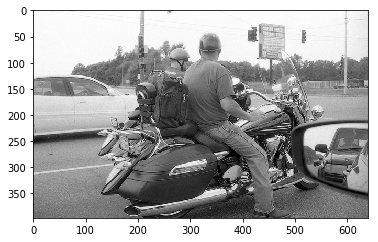

In [14]:
# show one example in other_img
first_single_layer_img = other_img[0]
image = mpimg.imread('coco/images/' + first_single_layer_img['file_path'])
print(image.shape)
plt.imshow(image,cmap='gray')